In [1]:
## Loading PyTorch library
!pip3 install torch

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6164e000 @  0x7f184887f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [3]:
## Loading torchvision library
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 16.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [32]:
!pwd && ls -l 
!ls -l 
!mkdir data

import os
os.chdir("data")

#上传Titannic数据文件
#上传本地文件到云端 
from google.colab import files
uploaded = files.upload()

!!unzip images.zip

/content
total 4
drwxr-xr-x 1 root root 4096 Dec 18 20:29 sample_data
total 4
drwxr-xr-x 1 root root 4096 Dec 18 20:29 sample_data


Saving images.zip to images.zip


In [36]:
import os
os.chdir("../")

!pwd

/content


In [38]:
#在google colab上不加这个，使用pillow会报错
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.2MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
# _*_ coding: utf-8 _*_
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms   #将PIL格式图片转为tensor表示
import torchvision.models as models

import copy



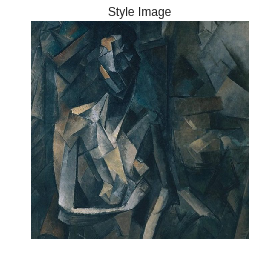

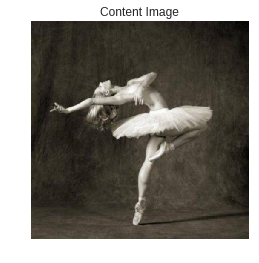

In [82]:
#选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load data
#输出图片大小
imsize = 512 if torch.cuda.is_available() else 128  #用CPU做时，尺寸小些

loader = transforms.Compose(
    [
        transforms.Resize(imsize),
        transforms.ToTensor()
    ])

def image_loader(image_name):
    image = Image.open(image_name)
    #输入的批量维度与网络要求的输入维度一致
    image = loader(image).unsqueeze(0)  #按行展开
    return image.to(device, torch.float)

style_img = image_loader("./data/images/neural-style/picasso.jpg")
content_img = image_loader("./data/images/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "We need to import style and content images of the same size"

unloader = transforms.ToPILImage()  #转化为PIL格式图片
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
#loss function

#content loss

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        #we 'detach' the target content from the tree used
        #to dynamically compute the gradient: this is a stated value,
        #not a variable. Otherwise the forward method of the criterion
        #will throw an error.
        #将target.detach() 的返回值将不再进行梯度计算，该返回值从当前的计算图中移除
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
#Style Loss

def gram_matrix(input):
    a, b, c, d = input.size() 
    #a=batch size(=1)
    #b=number of feature maps
    #(c, d)=dimensions of a f. map(N=c*d)
    
    features = input.view(a * b, c * d) #resize F_XL into \hat F_XL
    
    G = torch.mm(features, features.t())  #计算gram 矩阵
    
    #normalize the gram matrix
    #by dividing by the number of element in each feature maps
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        #self.loss = None
        
    def  forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [0]:
#导入模型VGG19
cnn = models.vgg19(pretrained=True).features.to(device).eval() #网络有些层在训练和预测阶段的表现不一致，如droupout。故必须在预测时用.eval()


#VGG模型的输入图片均值归一化参数[0.485,0.456,0.406],标准差归一化参数[0.229,0.224,0.225]
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#create a module to normalize input image so we can easily put it in a
#nn.Sequential

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
#desired depth layers to compute style/content losses:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    #归一化模型
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    #just in order to have an iterable access to or list of content/style losses
    content_losses = []
    style_losses = []
    
    #assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    #to put in modules that are supposed to be activated sequentially
    
    model = nn.Sequential(normalization)
    
    i = 0 #increment every time we see a conv
    
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with ContentLoss
            # and StyleLoss we insert below .So we replace with out-of-place
            # ones here
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RunTimeError('Unrecognized layer:{}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            #add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            #add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    # Now we trim off(去掉0) the layers after the last content anf style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
          
    model = model[:(i+1)]
    return model, style_losses, content_losses




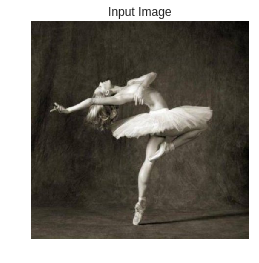

In [83]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
#L-BFGS 梯度下降算法
def get_input_optimizer(input_img):
    #this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
#风格迁移实现函数。每次迭代的输入为更像后的输入图片，输出为loss
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      sontent_img, style_img, input_img, num_steps=300,
                      style_weight=1000000, content_weight=1):
    """Run the style transfer"""
    print("Building the style transfer model...")
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print("Optimizing..")
    run = [0]
    
    while run[0] <= num_steps:
        def closure():
            #correct the values of updated input image
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score   *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0:
                print("run {}".format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(),
                                                                    content_score.item()))
                print()
             
            return style_score + content_score
        optimizer.step(closure)
        
    #a last corraction...
    input_img.data.clamp_(0, 1)
    return input_img


Building the style transfer model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]
Style Loss: 4.733151 Content Loss: 4.265424

run [100]
Style Loss: 1.190271 Content Loss: 3.096789

run [150]
Style Loss: 0.750905 Content Loss: 2.691856

run [200]
Style Loss: 0.497481 Content Loss: 2.512964

run [250]
Style Loss: 0.357611 Content Loss: 2.421621

run [300]
Style Loss: 0.271220 Content Loss: 2.365617



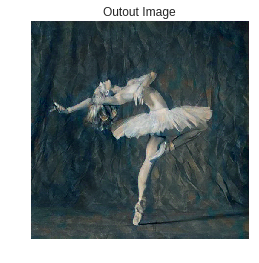

In [86]:
#跑起来
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                           content_img, style_img, input_img)

plt.figure()
imshow(output, title='Outout Image')

plt.ioff()
plt.show()